# Bonus1: Parallel Algorithms

### Name: Prakhar


## 0. You will do the following:

1. Read the lecture note: [click here](https://github.com/wangshusen/DeepLearning/blob/master/LectureNotes/Parallel/Parallel.pdf)

2. Implement federated averaging or decentralized optimization.

3. Plot the convergence curve. (The x-axis can be ```number of epochs``` or ```number of communication```. You must make sure the label is correct.)

4. Convert the .IPYNB file to .HTML file.

    * The HTML file must contain **the code** and **the output after execution**.
    
5. Upload this .HTML file to your Google Drive, Dropbox, or your Github repo. (If it is submitted to Google Drive or Dropbox, you must make the file open-access.)

6. Submit the link to this .HTML file to Canvas.

    * Example: https://github.com/wangshusen/CS583-2020S/blob/master/homework/Bonus1/Bonus1.html



# 1. Data processing

- Download the Diabete dataset from https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/diabetes
- Load the data using sklearn.
- Preprocess the data.

## 1.1. Load the data

In [1]:
from sklearn import datasets
import numpy

x_sparse, y = datasets.load_svmlight_file('diabetes')
x = x_sparse.todense()

print('Shape of x: ' + str(x.shape))
print('Shape of y: ' + str(y.shape))

Shape of x: (768, 8)
Shape of y: (768,)


## 1.2. Partition to training and test sets

In [2]:
# partition the data to training and test sets
n = x.shape[0]
n_train = 640
n_test = n - n_train

rand_indices = numpy.random.permutation(n)
train_indices = rand_indices[0:n_train]
test_indices = rand_indices[n_train:n]

x_train = x[train_indices, :]
x_test = x[test_indices, :]
y_train = y[train_indices].reshape(n_train, 1)
y_test = y[test_indices].reshape(n_test, 1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))
print('Shape of y_train: ' + str(y_train.shape))
print('Shape of y_test: ' + str(y_test.shape))

Shape of x_train: (640, 8)
Shape of x_test: (128, 8)
Shape of y_train: (640, 1)
Shape of y_test: (128, 1)


## 1.3. Feature scaling

Use the standardization to trainsform both training and test features

In [3]:
# Standardization
import numpy

# calculate mu and sig using the training set
d = x_train.shape[1]
mu = numpy.mean(x_train, axis=0).reshape(1, d)
sig = numpy.std(x_train, axis=0).reshape(1, d)

# transform the training features
x_train = (x_train - mu) / (sig + 1E-6)

# transform the test features
x_test = (x_test - mu) / (sig + 1E-6)

print('test mean = ')
print(numpy.mean(x_test, axis=0))

print('test std = ')
print(numpy.std(x_test, axis=0))

test mean = 
[[ 0.1752497   0.07261311  0.20823349 -0.24561856 -0.11109881 -0.01232122
  -0.15671796  0.20132643]]
test std = 
[[1.09205632 0.94805958 0.83531374 0.97451419 0.93868891 0.94414752
  0.94529316 1.1283392 ]]


## 1.4. Add a dimension of all ones

In [4]:
n_train, d = x_train.shape
x_train = numpy.concatenate((x_train, numpy.ones((n_train, 1))), axis=1)

n_test, d = x_test.shape
x_test = numpy.concatenate((x_test, numpy.ones((n_test, 1))), axis=1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))

Shape of x_train: (640, 9)
Shape of x_test: (128, 9)


In [5]:
class Worker:
    def __init__(self, x, y, q, alpha, lam, beta):
        self.x = x #s-by-d local feature matrix
        self.y = y #s-by-1 local label matrix
        self.s = x.shape[0] #number of local samples
        self.d = x.shape[1] #number of features
        self.w = numpy.zeros((self.d, 1)) #d-by-1 model parameter vecotr
        self.q = q #Number of times local gradient to be performed
        self.v = numpy.zeros((self.d, 1)) #d-by1 momentum
        self.alpha = alpha #Local learning rate
        self.initial_w = numpy.zeros((self.d, 1)) #To store the w broadcasted by server for finding direction at the end
        self.lam = lam #regularization parameter
        self.beta = beta #momentum parameter 
    #Set the model parameters to the latest
    def set_param(self, w):
        self.w = w
        self.initial_w = w
    
    #compute the local loss
    def loss(self):
        yx = numpy.multiply(self.y, self.x) #s-by-d matrix
        yxw = numpy.dot(yx, self.w) #s-by-1 matrix
        vec1 = numpy.exp(-yxw) #s-by-1 matrix
        vec2 = numpy.log(1 + vec1) #s-by-1 matrix
        reg = self.lam / 2*numpy.sum(self.w * self.w)
        losses = numpy.sum(vec2)/self.s + reg #loss function
        return losses
    
    #Compute the local gradient 
    def gradient(self):
        yx = numpy.multiply(self.y, self.x) # s-by-d
        yxw = numpy.dot(yx, self.w) # s-by-1
        vec1 = numpy.exp(yxw) # s-by-1
        vec2 = numpy.divide(yx, 1+vec1) # s-by-d
        reg = self.lam / 2*numpy.sum(self.w * self.w)
        g = -numpy.mean(vec2, axis=0).reshape(self.d, 1)+reg # d-by-1
        return g

    
    #Compute q gradient 
    def gradient_descent_local(self):
        for i in range(self.q):
            gradient = self.gradient()
            self.v = self.beta*self.v + gradient
            self.w -= self.alpha * self.v
            losses = self.loss()
            #print("local gradient ", gradient)
            print("local objective function value ", losses)
            #print("local w", self.w)
        return self.w
    
    #Compute Stochastic gradient descent
    def sgd(self, i, x_rand, y_rand):
        import numpy as np
        xi = x_rand[i,:]
        yi = float(y_rand[i,:])
        # calculate the stochastic gradient and local worker loss
        d = xi.shape[0]
        yx = yi * xi
        yxw = float(np.dot(yx, self.w))
        loss = np.log(1 + np.exp(-yxw))
        reg = lam / 2 * np.sum(self.w * self.w)
        obj = loss + reg
        gradient = -yx.T / (1 + np.exp(yxw))
        gradient = gradient + lam * self.w
        return gradient, obj
    
    #Compute q stochastic gradients 
    def stochgradient_descent_local(self):
        import numpy as np
        for i in range(self.q):
            rand_indices = np.random.permutation(self.s)
            x_rand = self.x[rand_indices,:]
            y_rand = self.y[rand_indices,:]
            stcobj = 0
            for i in range(self.s):
                gradient, obj = self.sgd(i, x_rand, y_rand)
                self.w -= self.alpha * gradient
                stcobj+=obj
            self.alpha *= 0.9 # decrease step size
            stcobj /= self.s
            #self.v = self.beta*self.v + gradient
            #self.w -= self.alpha * self.v
            #losses = self.loss()
            #print("local gradient ", gradient)
            print("local objective function value ", stcobj)
            #print("local w", self.w)
        return self.w
    
    #Find direction to be sent back to server
    def find_direction(self):
        pk = self.initial_w - self.gradient_descent_local()
        return pk
    
    #Find direction to be sent back to server stochastic gradient 
    def find_stochdirection(self):
        pk = self.initial_w - self.stochgradient_descent_local()
        return pk

In [6]:
class Server:
    def __init__(self, m, n, d, alpha, lam):
        self.m = m #number of worker nodes
        self.n = n #number of training samples
        self.d = d #number of features
        self.w = numpy.zeros((d, 1)) #d-by-1 model parameter vector
        self.pk = numpy.zeros((d, 1)) #directions recieved from different workers
        self.alpha = alpha #Server Learning rate
        self.lam = lam #Server reg parameter
        #self.g = numpy.zeros((d, 1)) #d-by-1 gradient
        #self.v = numpy.zeros((d, 1)) #d-by1 momentum
        self.loss = 0 #loss function value
        #self.obj = 0 #objective function value
    
    def broadcast(self):
        return self.w
    
    def aggregate(self, pk, losses):
        self.pk = numpy.mean(numpy.array(pk), axis=0)
        self.loss = sum(losses)
        #self.g = numpy.zeros((self.d, 1))
        #self.loss = 0
        #for k in range(self.m):
            #self.pk += pk[k]
            #self.loss += losses[k]
        #self.pk = self.pk/self.m
        
    def update(self):
        self.w = self.w - self.alpha*self.pk
        self.alpha *= 0.9 # decrease step size
            
    #Compute the objective function (sum of loss and regularization)
    def objective(self):
        reg = self.lam/2 * numpy.sum(self.w*self.w)
        self.obj = self.loss/self.m + reg
        return self.obj

In [7]:
import math

#Create a server and m worker nodes
def create_server_workers(m, x, y, q, alpha, lam, beta):
    n, d = x.shape
    s = math.floor(n / m)
    server = Server(m, n, d, alpha, lam)
    workers = []
    
    for i in range(m):
        indices = list(range(i*s, (i+1)*s))
        #print(x.shape)
        worker = Worker(x[indices, :], y[indices, :], q, alpha, lam, beta)
        workers.append(worker)
        
    return server, workers

m = 4 #number of worker nodes
q = 1
lam = 1E-4 #regularization parameter
alpha = 0.01 #learning rate
beta = 0.9 #momentum parameter 
server, workers = create_server_workers(m, x_train, y_train, q, alpha, lam, beta)

In [8]:
max_epoch = 50 #number of epochs
communication1 = 0 #number of communication
objective_val_1 = []
for t in range(max_epoch):
    print("----------------------------------epoch"+str(t)+"-------------------------------")
    #step 1: broadcast
    w = server.broadcast()
    communication1 = communication1+1
    for i in range(m):
        workers[i].set_param(w)
        
    #step 2: workers' local computations
    pk_1 = []
    losses_1 = []
    for i in range(m):
        print("Worker "+str(i+1))
        g = workers[i].find_direction()
        pk_1.append(g)
        l = workers[i].loss()
        losses_1.append(l)
        
    #step 3: aggregate the workers' outputs
    server.aggregate(pk_1, losses_1)
    communication1= communication1+1
    
    #step 4: server update the model parameters
    server.update() #compute gradient
    obj = server.objective() #compute objective function
    objective_val_1.append(obj)
    print('Objective function value = '+str(obj))

----------------------------------epoch0-------------------------------
Worker 1
local objective function value  0.6913322755334962
Worker 2
local objective function value  0.6906529179325918
Worker 3
local objective function value  0.6893384560156056
Worker 4
local objective function value  0.6880095127108329
Objective function value = 0.6898333010281349
----------------------------------epoch1-------------------------------
Worker 1
local objective function value  0.6837481783179109
Worker 2
local objective function value  0.6838319361165774
Worker 3
local objective function value  0.6811147406362832
Worker 4
local objective function value  0.6785981103300498
Objective function value = 0.681823328159477
----------------------------------epoch2-------------------------------
Worker 1
local objective function value  0.6714505385115996
Worker 2
local objective function value  0.6735828661846744
Worker 3
local objective function value  0.6693874288712268
Worker 4
local objective function

local objective function value  0.415530318720867
Worker 2
local objective function value  0.4956353420969346
Worker 3
local objective function value  0.4568954719827826
Worker 4
local objective function value  0.4928098360549183
Objective function value = 0.46534242508549395
----------------------------------epoch36-------------------------------
Worker 1
local objective function value  0.41469576879278386
Worker 2
local objective function value  0.4945853621252098
Worker 3
local objective function value  0.45653488948373455
Worker 4
local objective function value  0.49302411048502576
Objective function value = 0.4648370527236966
----------------------------------epoch37-------------------------------
Worker 1
local objective function value  0.4139527952073493
Worker 2
local objective function value  0.49360673934544996
Worker 3
local objective function value  0.45623323053608905
Worker 4
local objective function value  0.49326169992951807
Objective function value = 0.4643928251903675

In [9]:
import math

#Create a server and m worker nodes
def create_server_workers(m, x, y, q, alpha, lam, beta):
    n, d = x.shape
    s = math.floor(n / m)
    server = Server(m, n, d, alpha, lam)
    workers = []
    
    for i in range(m):
        indices = list(range(i*s, (i+1)*s))
        #print(x.shape)
        worker = Worker(x[indices, :], y[indices, :], q, alpha, lam, beta)
        workers.append(worker)
        
    return server, workers

m = 4 #number of worker nodes
q = 8
lam = 1E-4 #regularization parameter
alpha = 0.01 #learning rate
beta = 0.9 #momentum parameter 
server, workers = create_server_workers(m, x_train, y_train, q, alpha, lam, beta)

In [10]:
max_epoch = 50 #number of epochs
objective_val_8 = []
communication8 = 0
for t in range(max_epoch):
    print("----------------------------------epoch"+str(t)+"-------------------------------")
    #step 1: broadcast
    w = server.broadcast()
    communication8 = communication8+1
    for i in range(m):
        workers[i].set_param(w)
        
    #step 2: workers' local computations
    pk_8 = []
    losses_8 = []
    for i in range(m):
        print("Worker "+str(i+1))
        g = workers[i].find_direction()
        pk_8.append(g)
        l = workers[i].loss()
        losses_8.append(l)
        
    #step 3: aggregate the workers' outputs
    server.aggregate(pk_8, losses_8)
    communication8 = communication8+1
    
    #step 4: server update the model parameters
    server.update() #compute gradient
    obj = server.objective() #compute objective function
    objective_val_8.append(obj)
    print('Objective function value = '+str(obj))

----------------------------------epoch0-------------------------------
Worker 1
local objective function value  0.6913322755334962
local objective function value  0.6879158368108959
local objective function value  0.6831154631981242
local objective function value  0.677146521350205
local objective function value  0.6702170374485815
local objective function value  0.6625237610862807
local objective function value  0.6542492495032488
local objective function value  0.6455598439389749
Worker 2
local objective function value  0.656795805645259
local objective function value  0.6551863399409311
local objective function value  0.6529163802498992
local objective function value  0.6500792319001324
local objective function value  0.6467639832305992
local objective function value  0.6430543496764216
local objective function value  0.6390278700321325
local objective function value  0.6347554019967131
Worker 3
local objective function value  0.6307602561206549
local objective function value  0.62

local objective function value  0.40953536285358394
local objective function value  0.409341952296394
local objective function value  0.4091523893876464
local objective function value  0.40896658817659365
local objective function value  0.40878446604773566
local objective function value  0.4086059430720495
local objective function value  0.4084309415196884
Worker 2
local objective function value  0.4875083881467098
local objective function value  0.48678812046347175
local objective function value  0.48608998800904846
local objective function value  0.4854152658268106
local objective function value  0.4847648904984471
local objective function value  0.48413949741300755
local objective function value  0.48353945589738634
local objective function value  0.4829649021057575
Worker 3
local objective function value  0.4553335075515971
local objective function value  0.4546185078134116
local objective function value  0.45391077437979743
local objective function value  0.4532121358404474
local 

local objective function value  0.4510564874983983
local objective function value  0.4504312255438573
local objective function value  0.4498162298617233
local objective function value  0.4492125410052987
local objective function value  0.4486210019547753
local objective function value  0.4480422792544613
local objective function value  0.4474768826757271
Worker 4
local objective function value  0.5020356992353764
local objective function value  0.5011924128228993
local objective function value  0.5003582955053283
local objective function value  0.49953472137468513
local objective function value  0.49872286171839114
local objective function value  0.4979237047110289
local objective function value  0.4971380736246131
local objective function value  0.49636664361753624
Objective function value = 0.4590013223796746
----------------------------------epoch15-------------------------------
Worker 1
local objective function value  0.40864283948986935
local objective function value  0.408462559

local objective function value  0.44730180766100736
Worker 4
local objective function value  0.5023514014639505
local objective function value  0.5015007084906169
local objective function value  0.5006594980394327
local objective function value  0.49982912213398517
local objective function value  0.4990107317549886
local objective function value  0.49820529642528166
local objective function value  0.4974136223116569
local objective function value  0.4966363689057225
Objective function value = 0.45898323623339154
----------------------------------epoch22-------------------------------
Worker 1
local objective function value  0.40849475777960087
local objective function value  0.4083184290904266
local objective function value  0.4081437825628944
local objective function value  0.4079710437941772
local objective function value  0.4078004033410426
local objective function value  0.4076320203456888
local objective function value  0.40746602588086706
local objective function value  0.4073025

local objective function value  0.44842553260608503
local objective function value  0.44784993680659324
local objective function value  0.44728763264995763
Worker 4
local objective function value  0.5023759122117402
local objective function value  0.5015248181012074
local objective function value  0.5006832231335988
local objective function value  0.49985247778999053
local objective function value  0.4990337316686035
local objective function value  0.4982279530533673
local objective function value  0.49743594700089433
local objective function value  0.49665837200793456
Objective function value = 0.4589827832585563
----------------------------------epoch30-------------------------------
Worker 1
local objective function value  0.4084876709314845
local objective function value  0.4083115081048369
local objective function value  0.4081370186855327
local objective function value  0.4079644289562571
local objective function value  0.40779393011238546
local objective function value  0.407625

local objective function value  0.48744491580388255
local objective function value  0.4867235273429978
local objective function value  0.48602251458971607
local objective function value  0.48534344487875464
local objective function value  0.4846875232278617
local objective function value  0.484055630274296
Worker 3
local objective function value  0.45147851090473085
local objective function value  0.4508473895547639
local objective function value  0.45022529960730545
local objective function value  0.4496134860818249
local objective function value  0.44901297569232596
local objective function value  0.4484245993386245
local objective function value  0.4478490131361461
local objective function value  0.44728671796255803
Worker 4
local objective function value  0.5023780084508316
local objective function value  0.5015268890280953
local objective function value  0.500685269201241
local objective function value  0.4998544993941937
local objective function value  0.49903572915699707
local o

local objective function value  0.48405562946269176
Worker 3
local objective function value  0.4514783787602006
local objective function value  0.4508472595398147
local objective function value  0.4502251716291882
local objective function value  0.44961336005032
local objective function value  0.44901285152014125
local objective function value  0.4484244769417099
local objective function value  0.4478488924339343
local objective function value  0.44728659887813665
Worker 4
local objective function value  0.5023782400112472
local objective function value  0.5015271181230462
local objective function value  0.5006854958582038
local objective function value  0.49985472363544187
local objective function value  0.49903595100055803
local objective function value  0.49823014619367034
local objective function value  0.49743811423501855
local objective function value  0.4966605135913856
Objective function value = 0.45898274897437236
----------------------------------epoch45----------------------

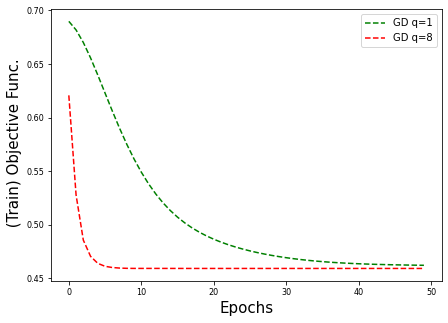

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(7, 5))

epochs_gd_1 = range(len(objective_val_1))
epochs_gd_8 = range(len(objective_val_8))

#epochs_gd_1 = range(int(communication1/2))
#epochs_gd_8 = range(int(communication1/2))


line0, = plt.plot(epochs_gd_1, objective_val_1, '--g', linewidth=1.5)
line1, = plt.plot(epochs_gd_8, objective_val_8, '--r', linewidth=1.5)

plt.xlabel('Epochs', fontsize=15)
plt.ylabel(' (Train) Objective Func.', fontsize=15)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.legend([line0, line1], ['GD q=1','GD q=8'], fontsize=10)
plt.show()

In [12]:
import math

#Create a server and m worker nodes
def create_server_workers(m, x, y, q, alpha, lam, beta):
    n, d = x.shape
    s = math.floor(n / m)
    server = Server(m, n, d, alpha, lam)
    workers = []
    
    for i in range(m):
        indices = list(range(i*s, (i+1)*s))
        #print(x.shape)
        worker = Worker(x[indices, :], y[indices, :], q, alpha, lam, beta)
        workers.append(worker)
        
    return server, workers

m = 4 #number of worker nodes
q = 1
lam = 1E-4 #regularization parameter
alpha = 0.01 #learning rate
beta = 0.9 #momentum parameter 
server, workers = create_server_workers(m, x_train, y_train, q, alpha, lam, beta)

In [13]:
max_epoch = 50 #number of epochs
sgd_objective_val_1 = []
for t in range(max_epoch):
    print("----------------------------------epoch"+str(t)+"-------------------------------")
    #step 1: broadcast
    w = server.broadcast()
    for i in range(m):
        workers[i].set_param(w)
        
    #step 2: workers' local computations
    sgd_pk_1 = []
    sgd_losses_1 = []
    for i in range(m):
        print("Worker "+str(i+1))
        g = workers[i].find_stochdirection()
        sgd_pk_1.append(g)
        l = workers[i].loss()
        sgd_losses_1.append(l)
        
    #step 3: aggregate the workers' outputs
    server.aggregate(sgd_pk_1, sgd_losses_1)
    
    #step 4: server update the model parameters
    server.update() #compute gradient
    obj = server.objective() #compute objective function
    sgd_objective_val_1.append(obj)
    print('Objective function value = '+str(obj))

----------------------------------epoch0-------------------------------
Worker 1
local objective function value  0.60733483619425
Worker 2
local objective function value  0.5627885377817693
Worker 3
local objective function value  0.515425565991126
Worker 4
local objective function value  0.5191636593820074
Objective function value = 0.5170536534428992
----------------------------------epoch1-------------------------------
Worker 1
local objective function value  0.4513565127208506
Worker 2
local objective function value  0.5085597996243639
Worker 3
local objective function value  0.4743258190132277
Worker 4
local objective function value  0.5036403903182477
Objective function value = 0.4721475690913016
----------------------------------epoch2-------------------------------
Worker 1
local objective function value  0.4296811778967175
Worker 2
local objective function value  0.49722920896432915
Worker 3
local objective function value  0.46468812119964287
Worker 4
local objective function

local objective function value  0.4508391376478831
Worker 4
local objective function value  0.4988953482194279
Objective function value = 0.4609542515136348
----------------------------------epoch26-------------------------------
Worker 1
local objective function value  0.4088544807331931
Worker 2
local objective function value  0.4879152370020541
Worker 3
local objective function value  0.450780230028698
Worker 4
local objective function value  0.4988395742666441
Objective function value = 0.4609849221829612
----------------------------------epoch27-------------------------------
Worker 1
local objective function value  0.4087968538228643
Worker 2
local objective function value  0.48788095646039853
Worker 3
local objective function value  0.4507278619694727
Worker 4
local objective function value  0.4987883709027483
Objective function value = 0.46101401170343514
----------------------------------epoch28-------------------------------
Worker 1
local objective function value  0.40874612

local objective function value  0.45030748516294594
Worker 4
local objective function value  0.4983791381926491
Objective function value = 0.46124072856464027
----------------------------------epoch49-------------------------------
Worker 1
local objective function value  0.40835369124682136
Worker 2
local objective function value  0.4875915148159196
Worker 3
local objective function value  0.4503023949835764
Worker 4
local objective function value  0.4983739415157925
Objective function value = 0.46124355062482936


In [14]:
import math

#Create a server and m worker nodes
def create_server_workers(m, x, y, q, alpha, lam, beta):
    n, d = x.shape
    s = math.floor(n / m)
    server = Server(m, n, d, alpha, lam)
    workers = []
    
    for i in range(m):
        indices = list(range(i*s, (i+1)*s))
        #print(x.shape)
        worker = Worker(x[indices, :], y[indices, :], q, alpha, lam, beta)
        workers.append(worker)
        
    return server, workers

m = 4 #number of worker nodes
q = 8
lam = 1E-4 #regularization parameter
alpha = 0.01 #learning rate
beta = 0.9 #momentum parameter 
server, workers = create_server_workers(m, x_train, y_train, q, alpha, lam, beta)

In [15]:
max_epoch = 50 #number of epochs
sgd_objective_val_8 = []
for t in range(max_epoch):
    print("----------------------------------epoch"+str(t)+"-------------------------------")
    #step 1: broadcast
    w = server.broadcast()
    for i in range(m):
        workers[i].set_param(w)
        
    #step 2: workers' local computations
    sgd_pk_8 = []
    sgd_losses_8 = []
    for i in range(m):
        print("Worker "+str(i+1))
        g = workers[i].find_stochdirection()
        sgd_pk_8.append(g)
        l = workers[i].loss()
        sgd_losses_8.append(l)
        
    #step 3: aggregate the workers' outputs
    server.aggregate(sgd_pk_8, sgd_losses_8)
    
    #step 4: server update the model parameters
    server.update() #compute gradient
    obj = server.objective() #compute objective function
    sgd_objective_val_8.append(obj)
    print('Objective function value = '+str(obj))

----------------------------------epoch0-------------------------------
Worker 1
local objective function value  0.6063601416421174
local objective function value  0.5118841039942761
local objective function value  0.4764000445283618
local objective function value  0.45732342911985047
local objective function value  0.44549839707130234
local objective function value  0.43781116619144883
local objective function value  0.43229414029144564
local objective function value  0.42808165230450756
Worker 2
local objective function value  0.5046338270913309
local objective function value  0.4948369766597331
local objective function value  0.48936907193207063
local objective function value  0.48634566431859005
local objective function value  0.48404671476694344
local objective function value  0.482317378593616
local objective function value  0.4806968391463138
local objective function value  0.4796701679292733
Worker 3
local objective function value  0.47045165092402924
local objective function v

local objective function value  0.45380517930031206
local objective function value  0.45362817933697297
Worker 4
local objective function value  0.4921912058013347
local objective function value  0.4918270099099352
local objective function value  0.49150335061902417
local objective function value  0.49121514850719983
local objective function value  0.4909583704645285
local objective function value  0.49072989208955875
local objective function value  0.4905257313848109
local objective function value  0.4903433444197874
Objective function value = 0.4610682560265073
----------------------------------epoch5-------------------------------
Worker 1
local objective function value  0.4121071339345729
local objective function value  0.412043444067847
local objective function value  0.4119863497120851
local objective function value  0.41193516549722775
local objective function value  0.41188921050910754
local objective function value  0.41184802534287124
local objective function value  0.4118110

local objective function value  0.489703679282605
local objective function value  0.4896989721856073
local objective function value  0.4896947367388506
local objective function value  0.4896909257633971
Worker 3
local objective function value  0.4543249073688663
local objective function value  0.45431990285367485
local objective function value  0.4543153996631326
local objective function value  0.45431134747666535
local objective function value  0.45430770116884006
local objective function value  0.4543044198842382
local objective function value  0.454301467156097
local objective function value  0.4542988099969808
Worker 4
local objective function value  0.49089911558782023
local objective function value  0.49089389998604344
local objective function value  0.4908892069441976
local objective function value  0.4908849839253418
local objective function value  0.49088118380811474
local objective function value  0.49087776410330636
local objective function value  0.4908746867660089
local ob

local objective function value  0.4116763585024043
local objective function value  0.4116763416496866
Worker 2
local objective function value  0.4897080401066284
local objective function value  0.4897079340086482
local objective function value  0.4897078385210216
local objective function value  0.48970775258259486
local objective function value  0.48970767523832787
local objective function value  0.48970760562877097
local objective function value  0.48970754298037
local objective function value  0.489707486596996
Worker 3
local objective function value  0.45430899839048305
local objective function value  0.45430892447076304
local objective function value  0.45430885794318854
local objective function value  0.4543087980685369
local objective function value  0.45430874418147527
local objective function value  0.4543086956832214
local objective function value  0.4543086520348874
local objective function value  0.45430861275145207
Worker 4
local objective function value  0.4908801208860184

local objective function value  0.48970773524476324
local objective function value  0.4897077341015428
local objective function value  0.48970773307264437
local objective function value  0.4897077321466362
local objective function value  0.4897077313132289
Worker 3
local objective function value  0.4543087633187414
local objective function value  0.45430876222615346
local objective function value  0.4543087612428248
local objective function value  0.4543087603578287
local objective function value  0.4543087595613321
local objective function value  0.45430875884448596
local objective function value  0.4543087581993239
local objective function value  0.4543087576186783
Worker 4
local objective function value  0.49087984015287034
local objective function value  0.49087983901397286
local objective function value  0.4908798379889653
local objective function value  0.49087983706645855
local objective function value  0.4908798362362024
local objective function value  0.49087983548897157
local

local objective function value  0.49087983588173856
Objective function value = 0.4617942762808378
----------------------------------epoch24-------------------------------
Worker 1
local objective function value  0.41167629206271644
local objective function value  0.41167629205578804
local objective function value  0.4116762920495528
local objective function value  0.41167629204394124
local objective function value  0.4116762920388902
local objective function value  0.4116762920343449
local objective function value  0.41167629203025397
local objective function value  0.41167629202657186
Worker 2
local objective function value  0.4897077350512616
local objective function value  0.48970773502808174
local objective function value  0.4897077350072204
local objective function value  0.4897077349884449
local objective function value  0.4897077349715472
local objective function value  0.4897077349563392
local objective function value  0.4897077349426519
local objective function value  0.489707

local objective function value  0.4908798359417096
local objective function value  0.4908798359412888
local objective function value  0.49087983594090917
local objective function value  0.4908798359405684
local objective function value  0.49087983594026063
Objective function value = 0.4617942763603109
----------------------------------epoch29-------------------------------
Worker 1
local objective function value  0.4116762920164234
local objective function value  0.411676292016321
local objective function value  0.4116762920162289
local objective function value  0.41167629201614575
local objective function value  0.41167629201607125
local objective function value  0.41167629201600386
local objective function value  0.41167629201594363
local objective function value  0.41167629201588934
Worker 2
local objective function value  0.4897077349855846
local objective function value  0.48970773498524156
local objective function value  0.4897077349849335
local objective function value  0.489707

local objective function value  0.4897077349845714
Worker 3
local objective function value  0.45430875979209145
local objective function value  0.454308759792083
local objective function value  0.4543087597920755
local objective function value  0.454308759792069
local objective function value  0.4543087597920632
local objective function value  0.45430875979205754
local objective function value  0.4543087597920531
local objective function value  0.45430875979204854
Worker 4
local objective function value  0.4908798359411707
local objective function value  0.4908798359411617
local objective function value  0.4908798359411544
local objective function value  0.4908798359411475
local objective function value  0.49087983594114126
local objective function value  0.49087983594113566
local objective function value  0.4908798359411299
local objective function value  0.4908798359411257
Objective function value = 0.4617942763614856
----------------------------------epoch34-------------------------

local objective function value  0.41167629201573364
local objective function value  0.41167629201573375
local objective function value  0.41167629201573364
Worker 2
local objective function value  0.4897077349845943
local objective function value  0.489707734984594
local objective function value  0.48970773498459375
local objective function value  0.48970773498459347
local objective function value  0.48970773498459363
local objective function value  0.4897077349845932
local objective function value  0.489707734984593
local objective function value  0.4897077349845933
Worker 3
local objective function value  0.4543087597920703
local objective function value  0.4543087597920703
local objective function value  0.45430875979206997
local objective function value  0.45430875979206997
local objective function value  0.45430875979207014
local objective function value  0.4543087597920697
local objective function value  0.4543087597920697
local objective function value  0.4543087597920697
Worker

local objective function value  0.4908798359411361
local objective function value  0.49087983594113593
Objective function value = 0.46179427636150366
----------------------------------epoch43-------------------------------
Worker 1
local objective function value  0.41167629201573447
local objective function value  0.4116762920157343
local objective function value  0.4116762920157343
local objective function value  0.4116762920157342
local objective function value  0.41167629201573436
local objective function value  0.4116762920157345
local objective function value  0.41167629201573447
local objective function value  0.4116762920157343
Worker 2
local objective function value  0.4897077349845926
local objective function value  0.4897077349845925
local objective function value  0.4897077349845923
local objective function value  0.4897077349845927
local objective function value  0.4897077349845927
local objective function value  0.4897077349845926
local objective function value  0.48970773

local objective function value  0.49087983594113593
Objective function value = 0.4617942763615036
----------------------------------epoch48-------------------------------
Worker 1
local objective function value  0.4116762920157345
local objective function value  0.4116762920157341
local objective function value  0.4116762920157343
local objective function value  0.41167629201573447
local objective function value  0.4116762920157343
local objective function value  0.4116762920157342
local objective function value  0.4116762920157343
local objective function value  0.4116762920157342
Worker 2
local objective function value  0.4897077349845926
local objective function value  0.48970773498459275
local objective function value  0.4897077349845925
local objective function value  0.4897077349845927
local objective function value  0.4897077349845927
local objective function value  0.48970773498459286
local objective function value  0.4897077349845926
local objective function value  0.489707734

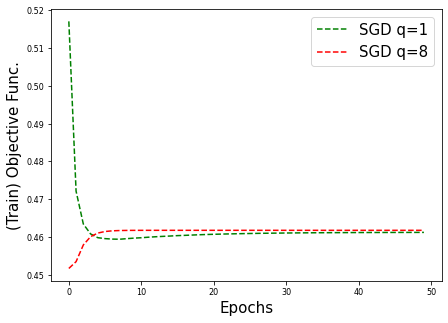

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(7, 5))

epochs_sgd_1 = range(len(sgd_objective_val_1))
epochs_sgd_8 = range(len(sgd_objective_val_8))


line0, = plt.plot(epochs_sgd_1, sgd_objective_val_1, '--g', linewidth=1.5)
line1, = plt.plot(epochs_sgd_8, sgd_objective_val_8, '--r', linewidth=1.5)

plt.xlabel('Epochs', fontsize=15)
plt.ylabel('(Train) Objective Func.', fontsize=15)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.legend([line0, line1], ['SGD q=1','SGD q=8'], fontsize=15)
plt.show()

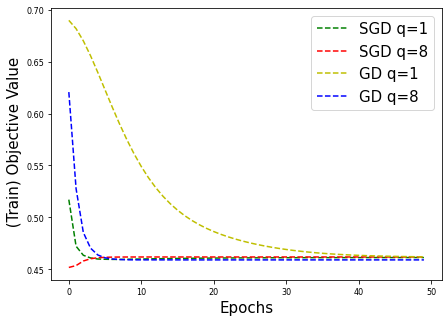

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(7, 5))

epochs_sgd_1 = range(len(sgd_objective_val_1))
epochs_sgd_8 = range(len(sgd_objective_val_8))


line0, = plt.plot(epochs_sgd_1, sgd_objective_val_1, '--g', linewidth=1.5)
line1, = plt.plot(epochs_sgd_8, sgd_objective_val_8, '--r', linewidth=1.5)
line2, = plt.plot(epochs_gd_1, objective_val_1, '--y', linewidth=1.5)
line3, = plt.plot(epochs_gd_8, objective_val_8, '--b', linewidth=1.5)

plt.xlabel('Epochs', fontsize=15)
plt.ylabel(' (Train) Objective Value', fontsize=15)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.legend([line0, line1, line2, line3], ['SGD q=1','SGD q=8', 'GD q=1', 'GD q=8'], fontsize=15)
plt.show()